In [41]:
from dataclasses import dataclass
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
from pathlib import Path
import numpy as np
import json
from matplotlib import patheffects
from utils import dref_dataframe, dump_dref, fmt_bytes
import matplotlib
from scipy import integrate, stats
from statistics import stdev

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sns.set_style("whitegrid")
sns.set_context("poster", font_scale=0.75)
sns.set_palette("colorblind6")


root = Path("multivm")


@dataclass
class BTimes:
    start: list[float]
    build: list[float]
    clean: list[float]
    cpu: dict[str, float]


def load_mode(path: Path, vm: int, i=0) -> tuple[pd.DataFrame, BTimes]:
    basedir = root / path / f"vm_{vm}"
    data = pd.read_csv(basedir / f"out_{i}.csv", dtype=np.float64).dropna()
    data = data.rename(columns={"rss": f"VM {vm}"})
    data[f"VM {vm}"] /= 1024 ** 3
    data = data[["time", f"VM {vm}"]]
    data.set_index("time")

    raw: dict = json.load((basedir / f"times_{i}.json").open())
    times = BTimes(
        [v / 60 for v in raw["start"]],
        [v / 60 for v in raw["build"]],
        [v / 60 for v in raw["clean"]],
        raw["cpu"],
    )
    return data, times


def load_data(max_mem: int, modes: dict[str, Path], vms: int) -> tuple[pd.DataFrame, list[BTimes]]:
    datas: list[pd.DataFrame] = []
    times: list[BTimes] = []
    for mode, path in modes.items():
        for vm in range(vms):
            data, time = load_mode(path, vm)
            datas.append(data)
            times.append(time)
    # data = pd.concat(datas, ignore_index=True)
    # merge and interpolate data
    data = datas[0]
    for d in datas[1:]:
        data = pd.merge_ordered(data, d, on="time", how="outer", fill_method="ffill")

    return data, times


def y_at(data: pd.DataFrame, x: float, measurement="VM memory"):
    return data[data["measurement"] == measurement][(data["time"] - x).abs() < 2/60]["bytes"].max()


def calc_gib_min(data: pd.DataFrame, start: float, end: float) -> float:
    build_d = data[(start <= data["time"])
        & (data["time"] <= end)
        & (data["measurement"] == "VM memory")]
    return integrate.trapezoid(build_d["bytes"], x=build_d["time"]) / 1024**3


def relplot(
        max_mem: int, data: pd.DataFrame,
        times: list[BTimes], col_wrap=10,
        run="build"
) -> tuple[sns.FacetGrid, dict[str, float]]:
    # col_wrap = min(col_wrap, len(data["mode"].unique()))
    # data = data[data["measurement"] == "VM memory"]
    # p = sns.relplot(data=data, kind="line", x="time", y="bytes", col="mode", col_wrap=col_wrap,
    #                 hue="vm", height=5.5, aspect=1.5, legend=False)
    # p.set_titles("{col_name}")
    # p.set(ylabel="Memory consumption [GiB]")
    # p.set(xlabel="Time [min]")
    # p.set(xlim=(0, None))
    # p.set(ylim=(0, max(max_mem * 1.1, data["bytes"].max() * 1.1)))
    # p.set(yticks=[x for x in range(0, max_mem + 1, 2*1024**3)],
    #     yticklabels=[str(x // 1024**3) for x in range(0, max_mem + 1, 2*1024**3)])

    # modes = data["mode"].unique()
    # extra_keys = {}

    # h = list(p.axes[0].get_lines())
    # l = list(data["vm"].unique())
    # p.add_legend(dict(zip(l, h)), loc="upper center", bbox_to_anchor=(0.3, 0.04), ncol=7, frameon=True)

    # p.refline(y=max_mem, color=sns.crayons["Gray"])

    # end_time = max([max(t.delay) for t in times])
    # total_gib_min = 0
    # for mode in modes:
    #     for vm in l:
    #         part = data[(data["mode"] == mode) & (data["vm"] == vm)]
    #         gib_min = calc_gib_min(part, 0, end_time)
    #         print(f"{mode} {vm}: {gib_min:.2f} GiB*min")
    #         total_gib_min += gib_min
    # print(f"Total: {total_gib_min:.2f} GiB*min")
    vms = data.columns[1:]
    print(vms)

    p = data.plot.area(x="time", stacked=True)
    p.set_ylabel("Memory consumption [GiB]")
    p.set_xlabel("Time [min]")
    p.set_ylim(0, (len(vms) * max_mem) / 1024**3)

    total_gib = data[vms].sum(axis=1)
    print(f"{integrate.trapezoid(total_gib, x=data['time']):.2f} GiB*min")

    return p, {}


def visualize(modes: dict[str, Path], save_as: str | None = None, col_wrap=10, run="build") -> sns.FacetGrid:
    meta = json.load((root / list(modes.values())[0] / "meta.json").open())
    max_mem = meta["args"]["mem"] * 1024**3
    data, times = load_data(max_mem, modes, meta["args"]["vms"])
    p, extra_keys = relplot(max_mem, data, times, col_wrap, run=run)
    if save_as:
        p.savefig(root / f"{save_as}.pdf")
        p.savefig(root / f"{save_as}.svg")
        dref_dataframe(save_as, root, ["mode", "measurement", "time"], data)
        with (root / f"{save_as}_extra.dref").open("w+") as f:
            dump_dref(f, save_as, extra_keys)
    return p

Index(['VM 0', 'VM 1', 'VM 2', 'VM 3'], dtype='object')
3267.80 GiB*min


<Axes: xlabel='Time [min]', ylabel='Memory consumption [GiB]'>

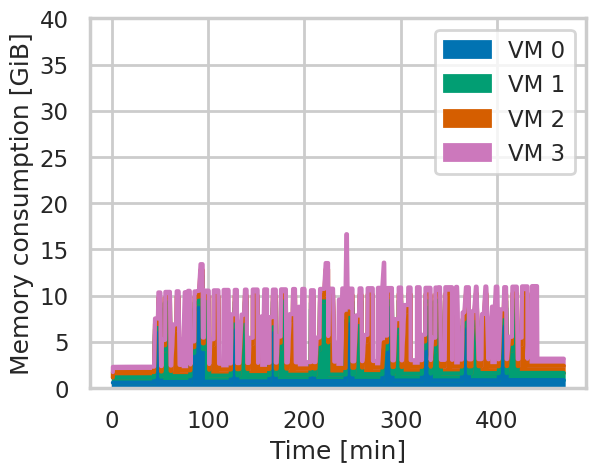

In [42]:
visualize(
    {
        "HyperAlloc": Path("250117-162908-write-llfree-auto"),
    }
)

Index(['VM 0', 'VM 1', 'VM 2', 'VM 3'], dtype='object')
6365.59 GiB*min


<Axes: xlabel='Time [min]', ylabel='Memory consumption [GiB]'>

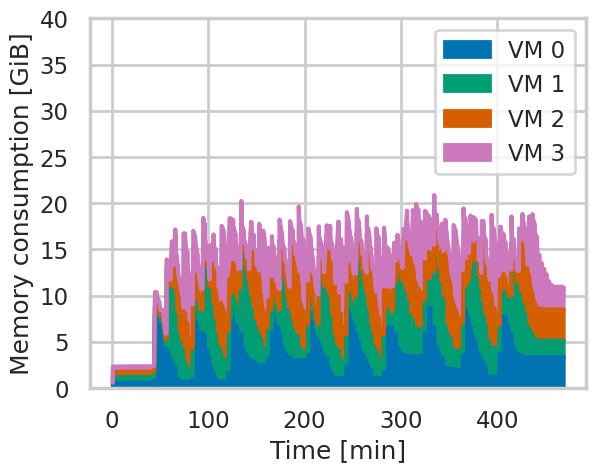

In [43]:
visualize(
    {
        "Baseline": Path("250117-185509-write-base-auto"),
    }
)

Index(['VM 0', 'VM 1', 'VM 2', 'VM 3'], dtype='object')
14337.57 GiB*min


<Axes: xlabel='Time [min]', ylabel='Memory consumption [GiB]'>

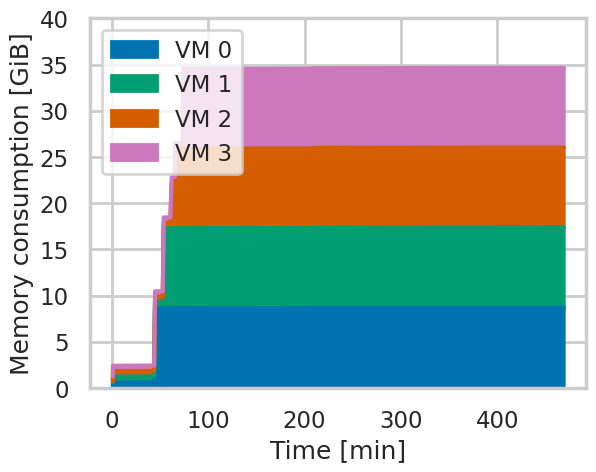

In [44]:
visualize(
    {
        "Baseline": Path("250117-182203-write-base-manual"),
    }
)

Index(['VM 0', 'VM 1', 'VM 2'], dtype='object')
1316077.18 GiB*min


<Axes: xlabel='Time [min]', ylabel='Memory consumption [GiB]'>

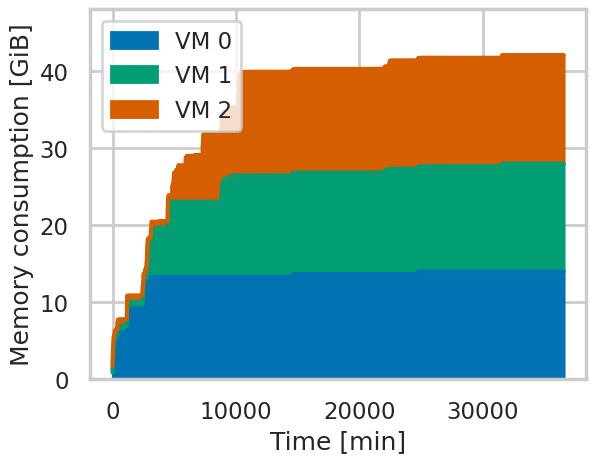

In [45]:
visualize(
    {
        "Baseline": Path("250119-011119-clang-base-manual"),
    }
)

Index(['VM 0', 'VM 1', 'VM 2'], dtype='object')
1168049.84 GiB*min


<Axes: xlabel='Time [min]', ylabel='Memory consumption [GiB]'>

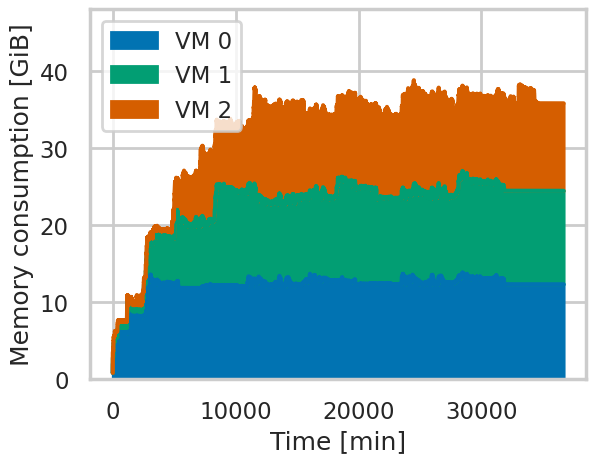

In [46]:
visualize(
    {
        "Baseline": Path("250119-112059-clang-base-auto"),
    }
)

Index(['VM 0', 'VM 1', 'VM 2'], dtype='object')
883973.71 GiB*min


<Axes: xlabel='Time [min]', ylabel='Memory consumption [GiB]'>

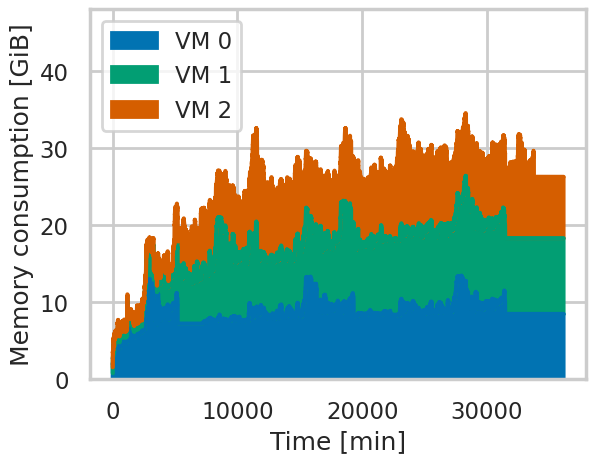

In [47]:
visualize(
    {
        "Baseline": Path("250119-213257-clang-llfree-auto"),
    }
)